In [1]:
# Running All Imports

import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import IBMQ, pulse

from qiskit.tools.monitor import job_monitor

from qiskit.visualization.pulse_v2 import stylesheet

from scipy.optimize import curve_fit

from typing import Optional

IBMQ.load_account()

/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_45131/2520264742.py:18: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
provider = IBMQ.get_provider(hub='ibm-q-nus', group='default', project='default')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibmq_kolkata') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibmq_mumbai') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_hanoi') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_algiers') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_cairo') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQ

In [3]:
DEBUG_PRINT = False

backend = provider.get_backend('ibm_cairo') # replace the name with the exact one for the backend that is desired from the previous displayed backends
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

dt = backend_config.dt # Example way of getting data on the backend
backend_defaults = backend.defaults() 

acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

lcm = np.lcm(acquire_alignment, pulse_alignment)

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# Experiments will be run on these qubits
qubit_0 = 0
qubit_1 = 1

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz_0 = backend_defaults.qubit_freq_est[qubit_0]
center_frequency_Hz_1 = backend_defaults.qubit_freq_est[qubit_1]

meas_freq_0 = backend_defaults.meas_freq_est[qubit_0]
meas_freq_1 = backend_defaults.meas_freq_est[qubit_1]

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

qubit = qubit_0

instruction_schedule_map = backend.defaults().instruction_schedule_map
measure_instructions = np.array(instruction_schedule_map.get("measure", qubits=[qubit]).instructions)
measure_pulse = measure_instructions[-2,1].pulse
measure_delay = measure_instructions[-1,1]

x_instructions = np.array(instruction_schedule_map.get("x", qubits=[qubit]).instructions)
x_pulse = x_instructions[0,1].pulse

sx_instructions = np.array(instruction_schedule_map.get("sx", qubits=[qubit]).instructions)
sx_pulse = sx_instructions[0,1].pulse

if DEBUG_PRINT:
    print(f"config: {backend_config}")

    for key, value in backend_config.to_dict().items():
        print(key)
        print(value)
    
    print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                            # 1e9 to get nanoseconds

    backend_config.timing_constraints

    print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

    print(f"Qubit {qubit_0} has an estimated frequency of {center_frequency_Hz_0 / GHz} GHz.")
    print(f"Qubit {qubit_1} has an estimated frequency of {center_frequency_Hz_1 / GHz} GHz.")

    print(f"Resonator for qubit {qubit_0} has an estimated frequency of {meas_freq_0 / GHz} GHz.")
    print(f"Resonator for qubit {qubit_1} has an estimated frequency of {meas_freq_1 / GHz} GHz.")

    print(f"measure_instructions: {measure_instructions}")

    print(f"measurement pulse: {measure_pulse}")
    print(f"measurement delay: {measure_delay}")
    print(f"x pulse: {x_pulse}")
    print(f"sx pulse: {sx_pulse}")

## Qubit-RR Dispersive Shift Charecterisation

In [4]:
from exp_classes.device_charecterisation import RRFreqSpec
from utils import acquisition_checker

freq_span = 8.0 * MHz
num_experiments = 296

rr_freq_exp = RRFreqSpec(
    qubit=qubit,
    backend=backend,
    freq_span=freq_span,
    num_experiments=num_experiments,
    fit_func_name='gaussian',
    chi_est=0.63 * MHz,
)

In [5]:
rr_freq_jobs, details = rr_freq_exp.get_jobs()
print(details)

{'Total Experiment Size': 592, 'Frequency Step Size (MHz)': 0.027, 'Frequency Span (MHz)': 8.0}


296


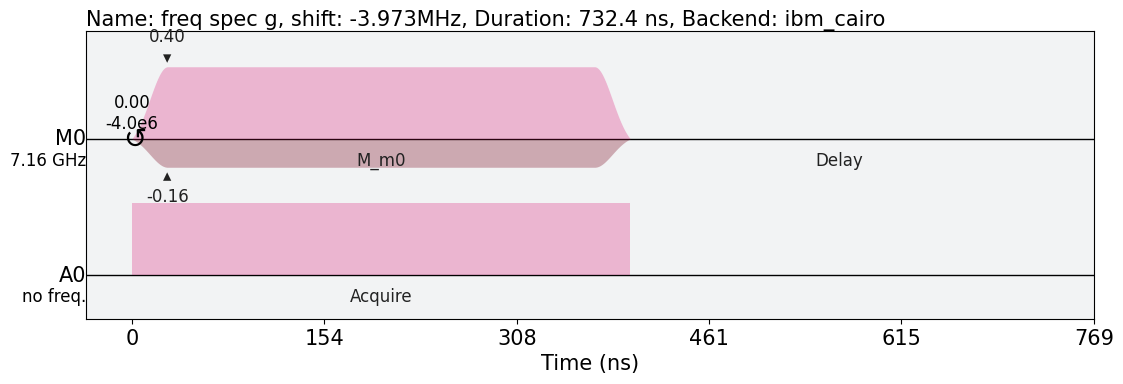

In [6]:
job_1, job_2 = np.array(rr_freq_jobs).reshape(2, -1).tolist()

num_shots = 4096
rep_delay = 499.0 * 1e-6

print(len(job_1))
job_1[1].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True,
)

In [19]:
# Running job_1, job_2

job_experiment = backend.run(job_2, 
                            meas_level=1, 
                            meas_return='single', 
                            shots=num_shots,
                            rep_delay=rep_delay)

job_monitor(job_experiment)

/Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/qiskit/compiler/assembler.py:443: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn(


Job Status: job is queued

KeyboardInterrupt: 

In [7]:
job_1 = provider.backend.retrieve_job('cpnbeb9dmm10008p1xqg')
job_2 = provider.backend.retrieve_job('cpnbedssp83g008y7070')

In [8]:
from utils import get_results_arr

results_1 = get_results_arr(job_1.result(), qubit)
results_2 = get_results_arr(job_2.result(), qubit)

In [9]:
results_1.shape

(291, 4096)

In [10]:
big_results = np.concatenate((results_1, results_2), axis=0)
big_results.shape

(582, 4096)

In [11]:
mean_abs_vals = np.abs(np.mean(big_results, axis=-1))

Freq G: 0.22073431659509876 MHz
Freq E: -0.37599538568749064 MHz
Dispersive Shift: 0.5967297022825894 MHz
Kappa G: -0.639850245301689 MHz
Kappa E: -0.5072528978075982 MHz
0.31710187340106283
0.3213339587007399


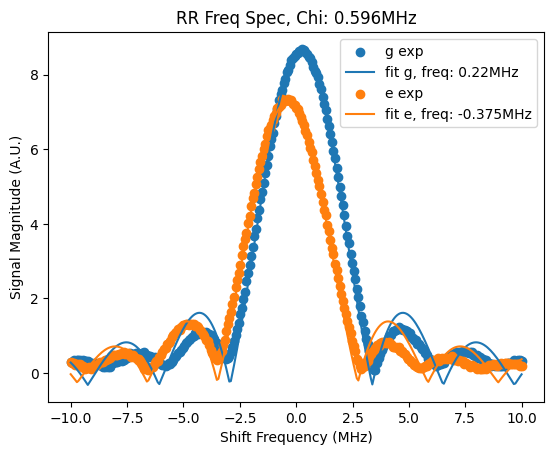

In [12]:
vals_g, vals_e = mean_abs_vals.reshape(2, -1)

freq_linspace = rr_freq_exp.freq_linspace/MHz

def sinc_func(x, a, b, c, d):
    return np.abs(a * np.sinc(b * (x - c))) + d

sinc_params_g, sinc_cov_g = curve_fit(sinc_func, freq_linspace, vals_g)
sinc_params_e, sinc_cov_e = curve_fit(sinc_func, freq_linspace, vals_e)

freq_g = sinc_params_g[2]
freq_e = sinc_params_e[2]

kappa_g = sinc_params_g[-1] * 2
kappa_e = sinc_params_e[-1] * 2

chi = freq_g - freq_e

print(f"Freq G: {freq_g} MHz")
print(f"Freq E: {freq_e} MHz")
print(f"Dispersive Shift: {freq_g - freq_e} MHz")
print(f"Kappa G: {kappa_g} MHz")
print(f"Kappa E: {kappa_e} MHz")
print(sinc_params_g[1])
print(sinc_params_e[1])


plt.scatter(freq_linspace, vals_g, label='g exp')
plt.plot(freq_linspace, sinc_func(freq_linspace, *sinc_params_g), label=f'fit g, freq: {int(1e3*freq_g)/1e3}MHz')
plt.scatter(freq_linspace, vals_e, label='e exp')
plt.plot(freq_linspace, sinc_func(freq_linspace, *sinc_params_e), label=f'fit e, freq: {int(1e3*freq_e)/1e3}MHz')
plt.legend()
plt.xlabel('Shift Frequency (MHz)')
plt.ylabel('Signal Magnitude (A.U.)')
plt.title(f'RR Freq Spec, Chi: {int(1e3*chi)/1e3}MHz')
plt.show()